In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import copy
import shap
import pickle
import os

from scipy import linalg
from scipy.special import expit
from scipy import stats
from tqdm import tqdm
from matplotlib import cm
from sklearn.base import TransformerMixin, ClassifierMixin
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, 
                              RandomForestRegressor, GradientBoostingRegressor)
from sklearn.model_selection import KFold
from sklearn.metrics import (roc_auc_score, f1_score, precision_score, recall_score, 
                             RocCurveDisplay, PrecisionRecallDisplay, 
                             mean_squared_error)
from sklearn.preprocessing import OneHotEncoder
from pandas.api.types import CategoricalDtype

## Primary analysis

In [2]:
# Load F1 scores
mimic_f1 = {}
results_path = "../../results/metrics/"
basemdlname = "gbt"
model_iter_name = "_rpy2"
for c in ["CC", "Ensemble", "Weighting"]:
    mimic_f1[c] = pd.read_csv(results_path + "mimic_f1_{}_{}{}.csv".format(
        c, basemdlname, model_iter_name
    ), index_col=0)

In [3]:
mimic_f1["CC"]

,0.1,0.2,0.30000000000000004,0.4,0.5,0.6,0.7000000000000001,0.8,0.9,1.0
20000,0.159383,0.162047,0.166846,0.178123,0.191362,0.172122,0.055955,0.000000,0.000000,0.0
10000,0.155505,0.155844,0.160311,0.156974,0.171928,0.154941,0.080960,0.015564,0.000000,0.0
5000,0.160130,0.158606,0.153404,0.152648,0.160285,0.131206,0.063401,0.021898,0.007874,0.0
2000,0.156250,0.157895,0.143258,0.134545,0.139303,0.146341,0.052980,0.017857,0.000000,0.0
1000,0.161017,0.114613,0.126050,0.136364,0.120301,0.098039,0.077922,0.000000,0.000000,0.0


In [4]:
mimic_f1["Ensemble"]

,0.1,0.2,0.30000000000000004,0.4,0.5,0.6,0.7000000000000001,0.8,0.9,1.0
20000,0.158650,0.160646,0.166769,0.179932,0.192295,0.180211,0.059375,0.000000,0.0,0.0
10000,0.156801,0.158328,0.161071,0.172515,0.176887,0.152381,0.068536,0.000000,0.0,0.0
5000,0.161228,0.161814,0.157347,0.167581,0.165517,0.139286,0.053571,0.029851,0.0,0.0
2000,0.159170,0.163225,0.162424,0.148148,0.143921,0.134529,0.082192,0.019048,0.0,0.0
1000,0.158845,0.159624,0.151316,0.150235,0.165414,0.191489,0.060606,0.000000,0.0,0.0


In [5]:
mimic_f1["Weighting"]

,0.1,0.2,0.30000000000000004,0.4,0.5,0.6,0.7000000000000001,0.8,0.9,1.0
20000,0.158625,0.160109,0.164890,0.177166,0.188437,0.182112,0.090226,0.011650,0.0,0.0
10000,0.156458,0.159150,0.160904,0.166563,0.176169,0.163150,0.101648,0.011516,0.0,0.0
5000,0.160486,0.161020,0.160237,0.165386,0.153141,0.153191,0.096203,0.036364,0.0,0.0
2000,0.157265,0.161850,0.168729,0.155556,0.157791,0.153846,0.117647,0.000000,0.0,0.0
1000,0.161580,0.153173,0.144928,0.145594,0.180851,0.147059,0.106383,0.064516,0.0,0.0


In [6]:
# Compare the 3 models from MIMIC20k

thresholds = np.linspace(0.1, 1, 10)
n = 20000
scoreslist = []
modelnames = {"CC": "CCGBT", "Ensemble": "EnsGBT", "Weighting": "WtGBT"}
for c in ["CC", "Ensemble", "Weighting"]:
    scoreslist.append(pd.DataFrame({
        "Threshold": thresholds,
        "Model": modelnames[c],
        "F1": mimic_f1[c].loc[n].values
    }))

scores1 = pd.concat(scoreslist, ignore_index=True)
scores1

,Threshold,Model,F1
0,0.1,CCGBT,0.159383
1,0.2,CCGBT,0.162047
2,0.3,CCGBT,0.166846
3,0.4,CCGBT,0.178123
4,0.5,CCGBT,0.191362
5,0.6,CCGBT,0.172122
6,0.7,CCGBT,0.055955
7,0.8,CCGBT,0.000000
8,0.9,CCGBT,0.000000
9,1.0,CCGBT,0.000000


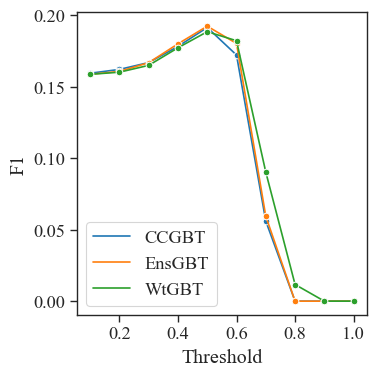

In [7]:
sns.set_style('ticks', {'font.family': ['Times New Roman']})
sns.set_context('paper', font_scale=1.5)

f1, ax = plt.subplots(figsize=(4, 4))
sns.lineplot(scores1, x="Threshold", y="F1", hue="Model", marker="o", ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels[0:])
f1.tight_layout()

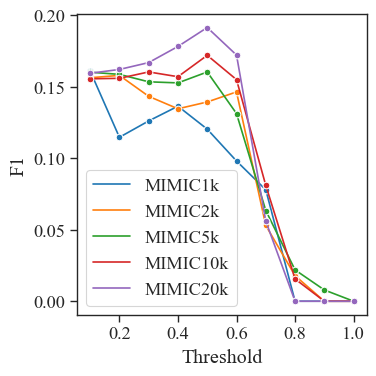

In [8]:
# Compare CCGBT over N

scoreslist = []
Ns = [1000, 2000, 5000, 10000, 20000]
c = "CC"
datanames = {1000: "MIMIC1k", 2000: "MIMIC2k", 5000: "MIMIC5k", 
             10000: "MIMIC10k", 20000: "MIMIC20k"}
for n in Ns:
    scoreslist.append(pd.DataFrame({
        "Threshold": thresholds,
        "Data": datanames[n],
        "F1": mimic_f1[c].loc[n].values
    }))

scores2 = pd.concat(scoreslist, ignore_index=True)

sns.set_style('ticks', {'font.family': ['Times New Roman']})
sns.set_context('paper', font_scale=1.5)

f2, ax = plt.subplots(figsize=(4, 4))
sns.lineplot(scores2, x="Threshold", y="F1", hue="Data", marker="o", ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels[0:])
f2.tight_layout()

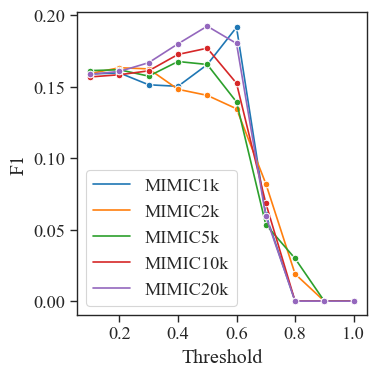

In [9]:
# Compare EnsGBT over N

scoreslist = []
Ns = [1000, 2000, 5000, 10000, 20000]
c = "Ensemble"
datanames = {1000: "MIMIC1k", 2000: "MIMIC2k", 5000: "MIMIC5k", 
             10000: "MIMIC10k", 20000: "MIMIC20k"}
for n in Ns:
    scoreslist.append(pd.DataFrame({
        "Threshold": thresholds,
        "Data": datanames[n],
        "F1": mimic_f1[c].loc[n].values
    }))

scores3 = pd.concat(scoreslist, ignore_index=True)

sns.set_style('ticks', {'font.family': ['Times New Roman']})
sns.set_context('paper', font_scale=1.5)

f3, ax = plt.subplots(figsize=(4, 4))
sns.lineplot(scores3, x="Threshold", y="F1", hue="Data", marker="o", ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels[0:])
f3.tight_layout()

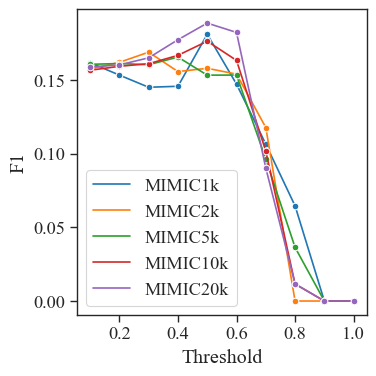

In [10]:
# Compare WtGBT over N

scoreslist = []
Ns = [1000, 2000, 5000, 10000, 20000]
c = "Weighting"
datanames = {1000: "MIMIC1k", 2000: "MIMIC2k", 5000: "MIMIC5k", 
             10000: "MIMIC10k", 20000: "MIMIC20k"}
for n in Ns:
    scoreslist.append(pd.DataFrame({
        "Threshold": thresholds,
        "Data": datanames[n],
        "F1": mimic_f1[c].loc[n].values
    }))

scores4 = pd.concat(scoreslist, ignore_index=True)

sns.set_style('ticks', {'font.family': ['Times New Roman']})
sns.set_context('paper', font_scale=1.5)

f4, ax = plt.subplots(figsize=(4, 4))
sns.lineplot(scores4, x="Threshold", y="F1", hue="Data", marker="o", ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels[0:])
f4.tight_layout()

In [11]:
# Save figures
plots_path = "../../results/figures/f1_analysis/"
if not os.path.exists(plots_path):
    os.mkdir(plots_path)

f1.savefig(plots_path + "f1_mimic20k.pdf", dpi=300)
f2.savefig(plots_path + "f1_ccgbt.pdf", dpi=300)
f3.savefig(plots_path + "f1_ensgbt.pdf", dpi=300)
f4.savefig(plots_path + "f1_wtgbt.pdf", dpi=300)

## Sensitivity analysis

In [12]:
# Load F1 scores
mimic_f1_sens = {}
results_path = "../../results/metrics/"
basemdlname = "gbt"
model_iter_name = "_rpy2"
for c in ["CC", "Ensemble", "Weighting"]:
    mimic_f1_sens[c] = pd.read_csv(results_path + "mimic_sens_f1_{}_{}{}.csv".format(
        c, basemdlname, model_iter_name
    ), index_col=0)

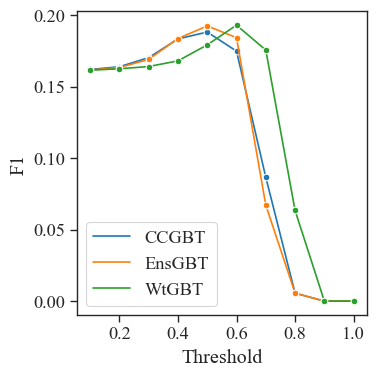

In [13]:
# Compare the 3 models from MIMIC20k

thresholds = np.linspace(0.1, 1, 10)
n = 20000
scoreslist = []
modelnames = {"CC": "CCGBT", "Ensemble": "EnsGBT", "Weighting": "WtGBT"}
for c in ["CC", "Ensemble", "Weighting"]:
    scoreslist.append(pd.DataFrame({
        "Threshold": thresholds,
        "Model": modelnames[c],
        "F1": mimic_f1_sens[c].loc[n].values
    }))

scores1s = pd.concat(scoreslist, ignore_index=True)
scores1s

sns.set_style('ticks', {'font.family': ['Times New Roman']})
sns.set_context('paper', font_scale=1.5)

f1s, ax = plt.subplots(figsize=(4, 4))
sns.lineplot(scores1s, x="Threshold", y="F1", hue="Model", marker="o", ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels[0:])
f1s.tight_layout()

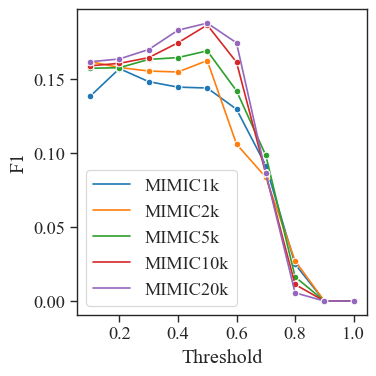

In [14]:
# Compare CCGBT over N

scoreslist = []
Ns = [1000, 2000, 5000, 10000, 20000]
c = "CC"
datanames = {1000: "MIMIC1k", 2000: "MIMIC2k", 5000: "MIMIC5k", 
             10000: "MIMIC10k", 20000: "MIMIC20k"}
for n in Ns:
    scoreslist.append(pd.DataFrame({
        "Threshold": thresholds,
        "Data": datanames[n],
        "F1": mimic_f1_sens[c].loc[n].values
    }))

scores2s = pd.concat(scoreslist, ignore_index=True)

sns.set_style('ticks', {'font.family': ['Times New Roman']})
sns.set_context('paper', font_scale=1.5)

f2s, ax = plt.subplots(figsize=(4, 4))
sns.lineplot(scores2s, x="Threshold", y="F1", hue="Data", marker="o", ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels[0:])
f2s.tight_layout()

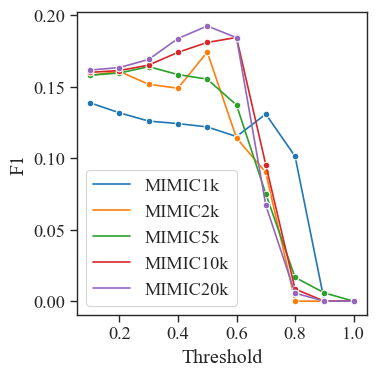

In [15]:
# Compare EnsGBT over N

scoreslist = []
Ns = [1000, 2000, 5000, 10000, 20000]
c = "Ensemble"
datanames = {1000: "MIMIC1k", 2000: "MIMIC2k", 5000: "MIMIC5k", 
             10000: "MIMIC10k", 20000: "MIMIC20k"}
for n in Ns:
    scoreslist.append(pd.DataFrame({
        "Threshold": thresholds,
        "Data": datanames[n],
        "F1": mimic_f1_sens[c].loc[n].values
    }))

scores3s = pd.concat(scoreslist, ignore_index=True)

sns.set_style('ticks', {'font.family': ['Times New Roman']})
sns.set_context('paper', font_scale=1.5)

f3s, ax = plt.subplots(figsize=(4, 4))
sns.lineplot(scores3s, x="Threshold", y="F1", hue="Data", marker="o", ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels[0:])
f3s.tight_layout()

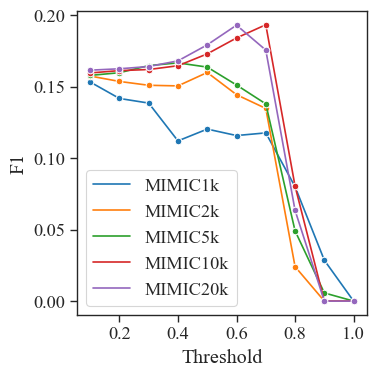

In [16]:
# Compare WtGBT over N

scoreslist = []
Ns = [1000, 2000, 5000, 10000, 20000]
c = "Weighting"
datanames = {1000: "MIMIC1k", 2000: "MIMIC2k", 5000: "MIMIC5k", 
             10000: "MIMIC10k", 20000: "MIMIC20k"}
for n in Ns:
    scoreslist.append(pd.DataFrame({
        "Threshold": thresholds,
        "Data": datanames[n],
        "F1": mimic_f1_sens[c].loc[n].values
    }))

scores4s = pd.concat(scoreslist, ignore_index=True)

sns.set_style('ticks', {'font.family': ['Times New Roman']})
sns.set_context('paper', font_scale=1.5)

f4s, ax = plt.subplots(figsize=(4, 4))
sns.lineplot(scores4s, x="Threshold", y="F1", hue="Data", marker="o", ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[0:], labels=labels[0:])
f4s.tight_layout()

In [17]:
# Save figures
plots_path = "../../results/figures/f1_analysis/"
if not os.path.exists(plots_path):
    os.mkdir(plots_path)

f1s.savefig(plots_path + "f1_sens_mimic20k.pdf", dpi=300)
f2s.savefig(plots_path + "f1_sens_ccgbt.pdf", dpi=300)
f3s.savefig(plots_path + "f1_sens_ensgbt.pdf", dpi=300)
f4s.savefig(plots_path + "f1_sens_wtgbt.pdf", dpi=300)